## Pre-Processing

#### About the Dataset
The dataset contains records from both ischemic and hemorrhagic strokes. This dataset is used to predict whether a patient is likely to experience a stroke based on the input parameters like gender, age, various diseases, and smoking status. Each row in the data provides relevant information about the patient. We are going to use this dataset to train a ML model that predicts the likelihood of a person having a stroke based on 11 clinical features.


1) Removed id attribute

2) Smoking Status: [‘Unknown’, 'never smoked', 'formerly smoked', 'smokes'] 
    * Used Simple Imputer to predict entries that are marked ‘Unknown’ based on the most frequent category: ‘never smoked’
    * 1544/5110 = 30.21% entries that are ‘Unknown’
    * Used Ordinal Encoding because there is ordinality in the categorical values (some order or hierarchy), in other words there is a clear order of smoking status from never smoked to smokes, the categories have a meaningful sequence.
    * {'never smoked': 0, 'formerly smoked': 1, 'smokes': 2}

3) Work Type, Residence Type, Gender
    * Used One hot encoding because the variable is nominal

4) BMI: data is missing for a sizable amount of entries.
    * Used KNN Imputer to predict BMI for missing entries using K-nearest neighbors (k = 5)



In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from imblearn.combine import SMOTETomek
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score, recall_score, confusion_matrix

# Import and read the dataset
stroke_df = pd.read_csv('healthcare-dataset-stroke-data.csv')
display(stroke_df)

# Use Simple Imputer to predict missing categories in smoking_status based on most frequent category
stroke_df['smoking_status'].replace('Unknown', None, inplace=True)
most_freq_smoking_status = stroke_df['smoking_status'].mode()[0]
stroke_df['smoking_status'].fillna(most_freq_smoking_status, inplace=True)

# Use Ordinal Encoding for smoking status attribute because there is a ranking
oe = OrdinalEncoder(dtype='int', categories=[['never smoked', 'formerly smoked', 'smokes']])
stroke_df['smoking_status'] = oe.fit_transform(stroke_df[['smoking_status']])

# Use One Hot Encoding for work type because this variable is nominal
stroke_df = pd.get_dummies(stroke_df, columns=['work_type', 'Residence_type', 'gender'], dtype='int')
stroke_df['ever_married'] = stroke_df['ever_married'].replace({'No': 0, 'Yes': 1})

# Delete id column
del stroke_df['id']

# Use KNNImputer to predict BMI for missing entries using K-nearest neighbors
imputer = KNNImputer(n_neighbors=5, weights='distance')
stroke_df = pd.DataFrame(imputer.fit_transform(stroke_df), columns=stroke_df.columns)

# Normalize the data by scaling it to have a consistent range using Z-score normalization
scaler = StandardScaler()
stroke_df[['age','bmi','avg_glucose_level']] = scaler.fit_transform(stroke_df[['age','bmi','avg_glucose_level']])

# Find number of each outcome in the target class
value_counts = stroke_df['stroke'].value_counts()

print(f'Target Class: {value_counts}')



,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


Target Class: stroke
0.0    4861
1.0     249
Name: count, dtype: int64


## Exploratory Data Analysis and Visualization

To be completed

1) add pie chart comparing stroke and non stroke percentages

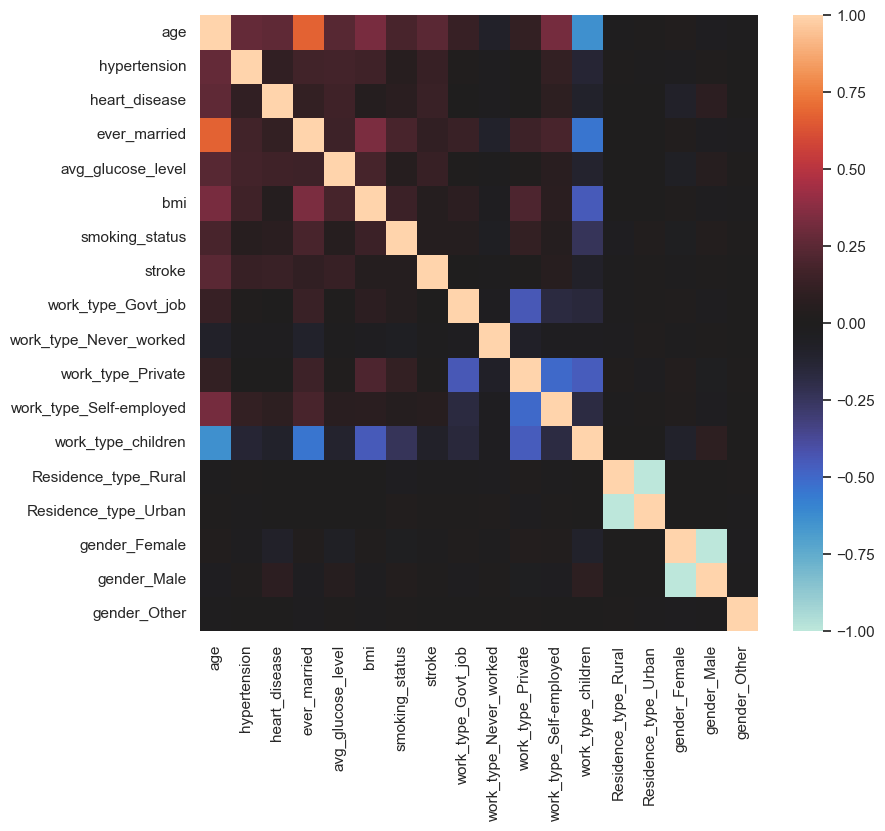

In [9]:
sns.set (rc = {'figure.figsize':(9, 8)})
sns.heatmap(stroke_df.corr(), vmin=-1, vmax=1, center=0, fmt='.1g')
plt.show()

## Metric for Evaluation : Recall

As we can see in our pie chart, our dataset is imbalanced as there are 4861 (95.12%) entries that are classified as negative for stroke as opposed to only 249 (4.87%) entries that are classified as positive for stroke. When our model is trained with this imbalanced dataset, the accuracy score would be close to 1 but our model performance would be very poor since the model is just guessing the majority class every time. Using accuracy score as a metric in this scenario would give you the false idea that the model is performing very well. Because our dataset is imbalanced, a better metric that can be used to measure model performance is ROC AUC, f1 scores, balanced error rates, precision, and recall. However, since this is a medical application, we should use recall to evaluate model performance because we want to point out and prevent as many risky patients as possible even if we must sacrifice precision. Since we would like to reduce false negatives as much as possible and have as many true positives as possible, recall would give us a ratio of TP to the total of FN and TP. The higher the recall the better. We don't mind false positives as we are interested in warning and preventing as opposed to under reporting.

## Oversampling Technique: SMOTE Tomek

There are three ways to handle dataset imbalance:

1) Upsample the minority class to match the number of samples in the majority class

2) Downsample the class with most observations

3) Choose a classifier that can deal with imbalance classes (SVC, decision trees)

Since our dataset is small, exclusively downsampling would cause significant loss of data. Instead, we performed SMOTE-Tomek oversampling on our dataset in order to combat the imbalance. SMOTE was used to oversample the minority class, in this case, the stroke positive class. SMOTE generates synthetic data which avoids loss of data and minimizes overfitting. Then Tomek links are used to remove potentially noisy samples. This hybrid technique provieds a balanced, more cleaner dataset for training ML models.


In [2]:
X = stroke_df.drop(['stroke'], axis=1)
y = stroke_df['stroke']

# Splitting the dataset into training and test partitions
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=420, test_size=0.25)

# Applying SMOTETomek resampling on the training partition
smt = SMOTETomek(random_state=69)
X_train, y_train = smt.fit_resample(X_train, y_train)

value_counts = y_train.value_counts()
print(f"Target Class:{value_counts}")

Target Class:stroke
0.0    3632
1.0    3632
Name: count, dtype: int64


## Neural Network: Multi-Layer Perceptron Classifier w/ Backpropagation

Evaluation: MLP performed poorly in terms of recall. We observe that there are vastly more false negatives than true negatives. This tells us that the model fails to warn us about high risk patients.

### Hyperparameters: number of hidden neurons, layers

In [69]:
from sklearn.neural_network import MLPClassifier

hidden_layer_size = len(y_train) / len(stroke_df.columns)

param_grid = {
    'hidden_layer_sizes': [(int(hidden_layer_size / 2),), (int(hidden_layer_size / 4),), (int(hidden_layer_size / 6),)],
    'learning_rate_init': [0.01, 0.05, 0.09]
}

mlp = MLPClassifier(max_iter=2000, random_state=69, solver='adam', batch_size=200, activation='logistic')

grid = GridSearchCV(estimator=mlp, param_grid=param_grid, scoring='recall')
grid.fit(X_train, y_train)

print("Optimal Hyper-parameters: ", grid.best_params_)
print("Optimal recall: ", grid.best_score_)

Optimal Hyper-parameters:  {'hidden_layer_sizes': (201,), 'learning_rate_init': 0.01}
Optimal recall:  0.9887097813195099


                 precision    recall  f1-score   support

Stroke Negative       0.95      0.93      0.94      1213
Stroke Positive       0.12      0.17      0.14        65

       accuracy                           0.89      1278
      macro avg       0.54      0.55      0.54      1278
   weighted avg       0.91      0.89      0.90      1278

Balanced Accuracy Score: 0.5512270911281628
AUC Score: 0.7498002409791362
Recall: 0.16923076923076924


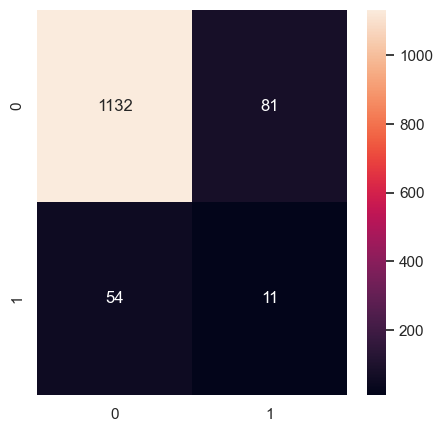

In [72]:
mlp = MLPClassifier(max_iter=2000, random_state=420, solver='adam', batch_size=200, activation='logistic', hidden_layer_sizes=(201,), learning_rate_init=0.01)
mlp.fit(X_train, y_train)

y_pred = mlp.predict(X_test)
y_prob_pred = mlp.predict_proba(X_test)[:, 1]

score = metrics.balanced_accuracy_score(y_test, y_pred)

fig, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d')

print(classification_report(y_test, y_pred, target_names=['Stroke Negative', 'Stroke Positive']))
print(f'Balanced Accuracy Score: {score}')
print(f'AUC Score: {roc_auc_score(y_test, y_prob_pred)}')
print(f'Recall: {recall_score(y_test, y_pred)}')



## Logistic Regression Classifier

Evaluation: Logistic Regression performed exceptional in terms of recall. We observe that there are minimal false negatives compared to true negatives. This tells us that the model succeeds in warning us about high risk patients. There's higher false positives but we don't mind raising awareness of high risk individuals. From hyperparameter tuning, we find that the class weight is higher for the positive class. This is because the positive class is the minority class and we want it to have equal weight in training the model as the majority class.

### Hyperparameters: solver, penalty, C, class weight

In [4]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=1000, random_state=69)

param_grid = {
    'solver': ['newton-cg', 'lbfgs', 'liblinear'],
    'penalty' : ['l2'],
    'C': [100, 10, 1.0, 0.1, 0.01],
    'class_weight' : [{0: 1, 1: 1}, {0: 1, 1: 1.1}, {0: 1, 1: 1.3}]
}

grid = GridSearchCV(estimator=lr, param_grid=param_grid, scoring='recall')
grid.fit(X_train, y_train)

print("Optimal Hyper-parameters: ", grid.best_params_)
print("Optimal recall: ", grid.best_score_)

Optimal Hyper-parameters:  {'C': 0.01, 'class_weight': {0: 1, 1: 1.3}, 'penalty': 'l2', 'solver': 'liblinear'}
Optimal recall:  0.8862781876537035


                 precision    recall  f1-score   support

Stroke Negative       0.99      0.69      0.81      1213
Stroke Positive       0.13      0.88      0.23        65

       accuracy                           0.70      1278
      macro avg       0.56      0.78      0.52      1278
   weighted avg       0.95      0.70      0.78      1278

Balanced Accuracy Score: 0.7814128987253472
AUC Score: 0.8377576257213519
Recall: 0.8769230769230769


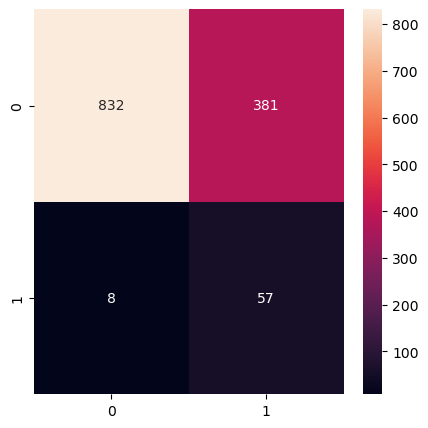

In [5]:
lr = LogisticRegression(max_iter=1000, random_state=69, solver='liblinear', class_weight={0: 1, 1: 1.3}, C=0.01, penalty='l2')
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)
y_prob_pred = lr.predict_proba(X_test)[:, 1]

score = metrics.balanced_accuracy_score(y_test, y_pred)

fig, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d')

print(classification_report(y_test, y_pred, target_names=['Stroke Negative', 'Stroke Positive']))
print(f'Balanced Accuracy Score: {score}')
print(f'AUC Score: {roc_auc_score(y_test, y_prob_pred)}')
print(f'Recall: {recall_score(y_test, y_pred)}')


## Random Forest Classifier

Evaluation: Random Forest performed poorly in terms of recall. We observe that there are vastly more false negatives than true negatives. This tells us that the model fails to warn us about high risk patients.

In [74]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=69)

param_grid = {
    'bootstrap': [True, False],
    'max_depth': [10, 50, 100],
    'n_estimators': [200, 800]
}

grid = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='recall')
grid.fit(X_train, y_train)

print("Optimal Hyper-parameters: ", grid.best_params_)
print("Optimal recall: ", grid.best_score_)

                 precision    recall  f1-score   support

Stroke Negative       0.95      0.96      0.96      1213
Stroke Positive       0.13      0.11      0.12        65

       accuracy                           0.92      1278
      macro avg       0.54      0.53      0.54      1278
   weighted avg       0.91      0.92      0.91      1278

Balanced Accuracy Score: 0.5344726996004819
AUC Score: 0.8377576257213519
Recall: 0.1076923076923077


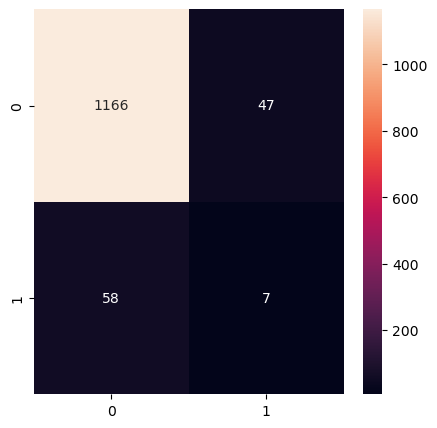

In [8]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(class_weight={0: 1, 1: 1.3}, random_state=69)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
y_prob_pred = lr.predict_proba(X_test)[:, 1]

score = metrics.balanced_accuracy_score(y_test, y_pred)

fig, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d')

print(classification_report(y_test, y_pred, target_names=['Stroke Negative', 'Stroke Positive']))
print(f'Balanced Accuracy Score: {score}')
print(f'AUC Score: {roc_auc_score(y_test, y_prob_pred)}')
print(f'Recall: {recall_score(y_test, y_pred)}')

## Save model

In [7]:
import pickle

# Save the trained model to a file using pickle.dump
with open('model_and_scaler.pkl', 'wb') as file:
    pickle.dump({'scaler': scaler, 'model': lr}, file)

# Load the model back from the file using pickle.load
with open('model_and_scaler.pkl', 'rb') as file:
    loaded_model = pickle.load(file)
